# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from prettytable import PrettyTable

In [2]:
# sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from scipy.stats import mode
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Initialisation

In [6]:
naive_sub= pd.read_parquet('taxi/naive_submission.parquet')
df= pd.read_parquet('taxi/train.parquet')
test= pd.read_parquet('taxi/test.parquet')

# Préparation des données

In [7]:
print("Nombre d'observations dans les données d'entraînement:",len(df))
print("Nombre d'observations dans les données test:",len(test))

Nombre d'observations dans les données d'entraînement: 100000
Nombre d'observations dans les données test: 2627163


# Variables

In [8]:
columns = list(df.columns)
print("Toutes les variables du jeu de données:")
print()
for i in range(0, len(columns), 5):
    print(", ".join(columns[i:i+5]))

Toutes les variables du jeu de données:

VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
RatecodeID, store_and_fwd_flag, payment_type, fare_amount, extra
mta_tax, tip_amount, tolls_amount, improvement_surcharge, congestion_surcharge
Airport_fee, PU_location_lat, PU_location_lon, DO_location_lat, DO_location_lon


In [9]:
# Vérification de données manquantes
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
congestion_surcharge     0
Airport_fee              0
PU_location_lat          0
PU_location_lon          0
DO_location_lat          0
DO_location_lon          0
dtype: int64

## Analyse exploratoire

In [12]:
# Résumé des variables
df_summary = df.describe(include='all').T
df_summary

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
VendorID,100000.0,NaN,NaN,NaN,1.75954,1.0,2.0,2.0,2.0,2.0,0.427365
tpep_pickup_datetime,100000,NaN,NaN,NaN,2024-01-17 01:37:59.341700,2023-12-31 23:56:46,2024-01-09 15:34:38,2024-01-17 11:32:54.500000,2024-01-24 18:09:36,2024-01-31 23:59:07,NaN
tpep_dropoff_datetime,100000,NaN,NaN,NaN,2024-01-17 01:53:39.024740,2024-01-01 00:03:50,2024-01-09 15:50:20.750000,2024-01-17 11:51:50,2024-01-24 18:28:48.500000,2024-02-01 10:57:24,NaN
passenger_count,100000.0,NaN,NaN,NaN,1.33509,0.0,1.0,1.0,1.0,7.0,0.847745
trip_distance,100000.0,NaN,NaN,NaN,3.213008,0.01,1.0,1.69,3.1,53.64,4.219928
RatecodeID,100000.0,NaN,NaN,NaN,1.99821,1.0,1.0,1.0,1.0,99.0,9.594546
store_and_fwd_flag,100000,2,N,99578,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_type,100000.0,NaN,NaN,NaN,1.18661,1.0,1.0,1.0,1.0,4.0,0.458398
fare_amount,100000.0,NaN,NaN,NaN,18.044264,0.0,8.6,12.8,19.8,214.8,15.839824
extra,100000.0,NaN,NaN,NaN,1.538507,0.0,0.0,1.0,2.5,11.75,1.788004


## Variable cible

Distribution

Estimation du paramètre lambda pour la distribution exponentielle : 0.29128833773251545


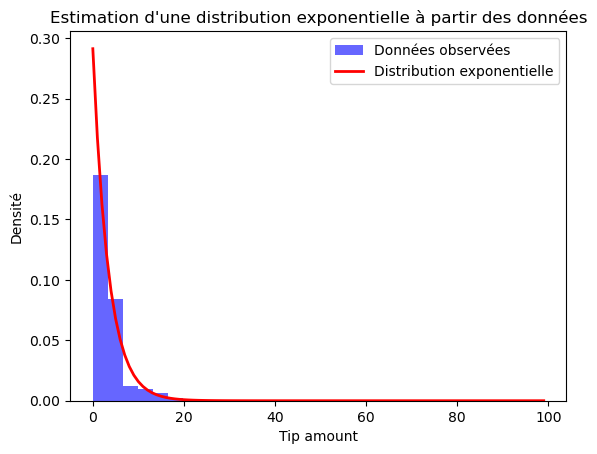

In [13]:
data = df['tip_amount']

# Ajouter une petite valeur aux pouboires nuls car la loi exponentielle >0
data = data.replace(0, 0.01)
mean_tip = data.mean()

# Estimer le paramètre lambda
lambda_estimate = 1 / mean_tip

print("Estimation du paramètre lambda pour la distribution exponentielle :", lambda_estimate)

x = np.linspace(0, data.max(), 100)
y = lambda_estimate * np.exp(-lambda_estimate * x)

# Créer un histogramme des données observées et superposer la distribution exponentielle estimée
plt.hist(data, bins=30, density=True, alpha=0.6, color='blue', label="Données observées")
plt.plot(x, y, 'r-', lw=2, label="Distribution exponentielle")
plt.xlabel("Tip amount")
plt.ylabel("Densité")
plt.title("Estimation d'une distribution exponentielle à partir des données")
plt.legend()
plt.show()

## Variables explicatives

In [14]:
# Déterminer quelles sont les variables qualitatives / quantitatives
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

VendorID: 2
tpep_pickup_datetime: 97567
tpep_dropoff_datetime: 97596
passenger_count: 8
trip_distance: 2412
RatecodeID: 6
store_and_fwd_flag: 2
payment_type: 4
fare_amount: 395
extra: 19
mta_tax: 2
tip_amount: 1808
tolls_amount: 119
improvement_surcharge: 3
congestion_surcharge: 2
Airport_fee: 2
PU_location_lat: 223
PU_location_lon: 223
DO_location_lat: 243
DO_location_lon: 243


In [15]:
# Variable qualitative ou quantitative
quantitative_vars = ['passenger_count','trip_distance', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon', 'fare_amount', 'tolls_amount', 'extra']
qualitative_vars = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']
variable_cible = 'tip_amount'

### Comparaison des valeurs entre les données test et entraînement

In [16]:
for col in ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']:
    print(col)
    print('Train: ',np.unique(df[col]))
    print('Test: ', np.unique(test[col]))

VendorID
Train:  [1 2]
Test:  [1 2]
RatecodeID
Train:  [ 1.  2.  3.  4.  5. 99.]
Test:  [ 1.  2.  3.  4.  5.  6. 99.]
store_and_fwd_flag
Train:  ['N' 'Y']
Test:  ['N' 'Y']
payment_type
Train:  [1 2 3 4]
Test:  [1 2 3 4]
mta_tax
Train:  [0.  0.5]
Test:  [0.  0.5 4. ]
improvement_surcharge
Train:  [0.  0.3 1. ]
Test:  [0.  0.3 1. ]
congestion_surcharge
Train:  [0.  2.5]
Test:  [0.  1.  2.5]
Airport_fee
Train:  [0.   1.75]
Test:  [0.   1.75]


In [17]:
new_values_in_test = pd.concat([test[test['mta_tax'] == 4.0], test[test['RatecodeID'] == 6.0], test[test['congestion_surcharge']==1.]])
new_values_in_test = new_values_in_test.drop_duplicates()

print(f"Nombres d'observations avec valeurs catégorilles inconnues:{len(new_values_in_test)}")
print(f"Rapport d'observations avec valeurs catégorilles inconnues dans les données test:{len(new_values_in_test)/len(test)}")

Nombres d'observations avec valeurs catégorilles inconnues:5
Rapport d'observations avec valeurs catégorilles inconnues dans les données test:1.9031936731752084e-06


### Analyse de RatecodeID

In [20]:
df_ratecode = df[df['RatecodeID']==99.]
print(f"Nombre de pourboires nuls pour le RatecodeID 99: {len(df_ratecode[df_ratecode['tip_amount']==0])}")
print(f"Nombre de pourboires non nuls pour le RatecodeID 99: {len(df_ratecode[df_ratecode['tip_amount']!=0])}")

Nombre de pourboires nuls pour le RatecodeID 99: 968
Nombre de pourboires non nuls pour le RatecodeID 99: 0


### Nombre de passagers

In [21]:
print(f"Nombre d'observations avec 7 passagers: {len(df[df['passenger_count']==5])}")
print(f"Nombre d'observations avec 7 passagers: {len(df[df['passenger_count']==6])}")
print(f"Nombre d'observations avec 8 passagers: {len(df[df['passenger_count']==7])}")

Nombre d'observations avec 7 passagers: 1121
Nombre d'observations avec 7 passagers: 840
Nombre d'observations avec 8 passagers: 1


In [22]:
print(f"Pourboire donné pour l'observation à 8 passagers: {df[df['passenger_count']==7]['tip_amount'].values[0]}")
print(f"Moyenne des pouboires {np.mean(df['tip_amount'])}")

Pourboire donné pour l'observation à 8 passagers: 15.3
Moyenne des pouboires 3.4309846000000004


In [23]:
# Supprime cette observation de nos données
# Nous définissons un nouveau dataframe sur lequel nous faisons des transformations
df_filtered = df.copy()
index_8 = df_filtered[df_filtered['passenger_count']==7].index
df_filtered = df_filtered.drop(index_8, axis=0)

## Transformation des données: numérique / catégorielle

In [25]:
# Convertir en numérique les colonnes qui devraient l'être
for col in quantitative_vars:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

for col in qualitative_vars:
    df_filtered[col] = df_filtered[col].astype('category')

# Variable binaire
for col in ['store_and_fwd_flag','VendorID', 'mta_tax', 'congestion_surcharge', 'Airport_fee']:
    df_filtered[col] = pd.factorize(df_filtered[col])[0] + 1

# Variable improvement surcharge
df_filtered['improvement_surcharge'] = pd.factorize(df_filtered['improvement_surcharge'])[0] + 1

# RatecodeID en entiers
df_filtered['RatecodeID'] = df_filtered['RatecodeID'].astype(int)

# Convertir les autres colonnes en type "category" pour les colonnes catégorielles
for col in qualitative_vars:
    df_filtered[col] = df_filtered[col].astype('category')

# Convertion en format data heure
df_filtered['tpep_pickup_datetime'] = pd.to_datetime(df_filtered['tpep_pickup_datetime'])
df_filtered['tpep_dropoff_datetime'] = pd.to_datetime(df_filtered['tpep_dropoff_datetime'])

In [26]:
# Dataframe avec toutes les valeurs du dataframe
df_long = pd.melt(df_filtered, var_name='Variables', value_name='Values')
df_long_rand = df_long[df_long['Variables'].isin(quantitative_vars+[variable_cible])] 

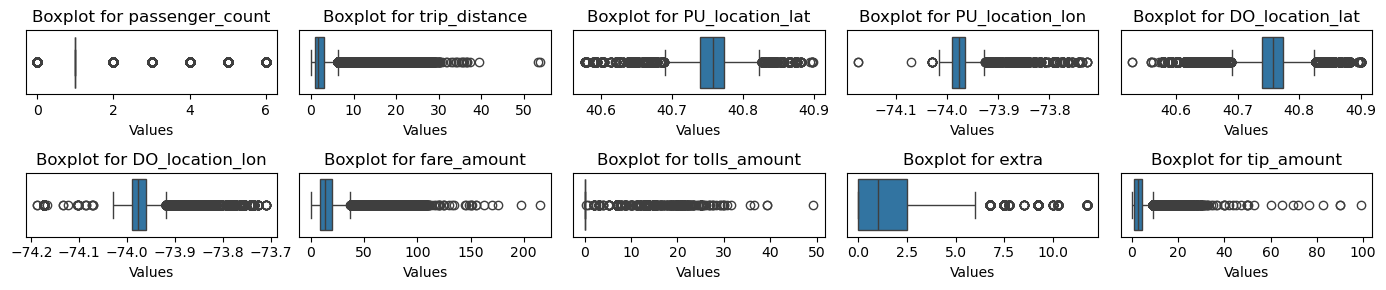

In [27]:
# Définir la taille de la figure pour s'adapter au nombre de sous-graphiques
fig, axes = plt.subplots(2,5, figsize=(14,3))
axes = axes.flatten()

# Tracer un boxplot par variable avec sa propre échelle
for i, var in enumerate(quantitative_vars+[variable_cible]):
    sns.boxplot(data=df_long_rand[df_long_rand['Variables'] == var],x="Values", y="Variables", ax=axes[i],dodge=False)
    axes[i].set_title(f"Boxplot for {var}")
    axes[i].set_ylabel('')
    axes[i].get_yaxis().set_visible(False)
    
# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

# Corrélation

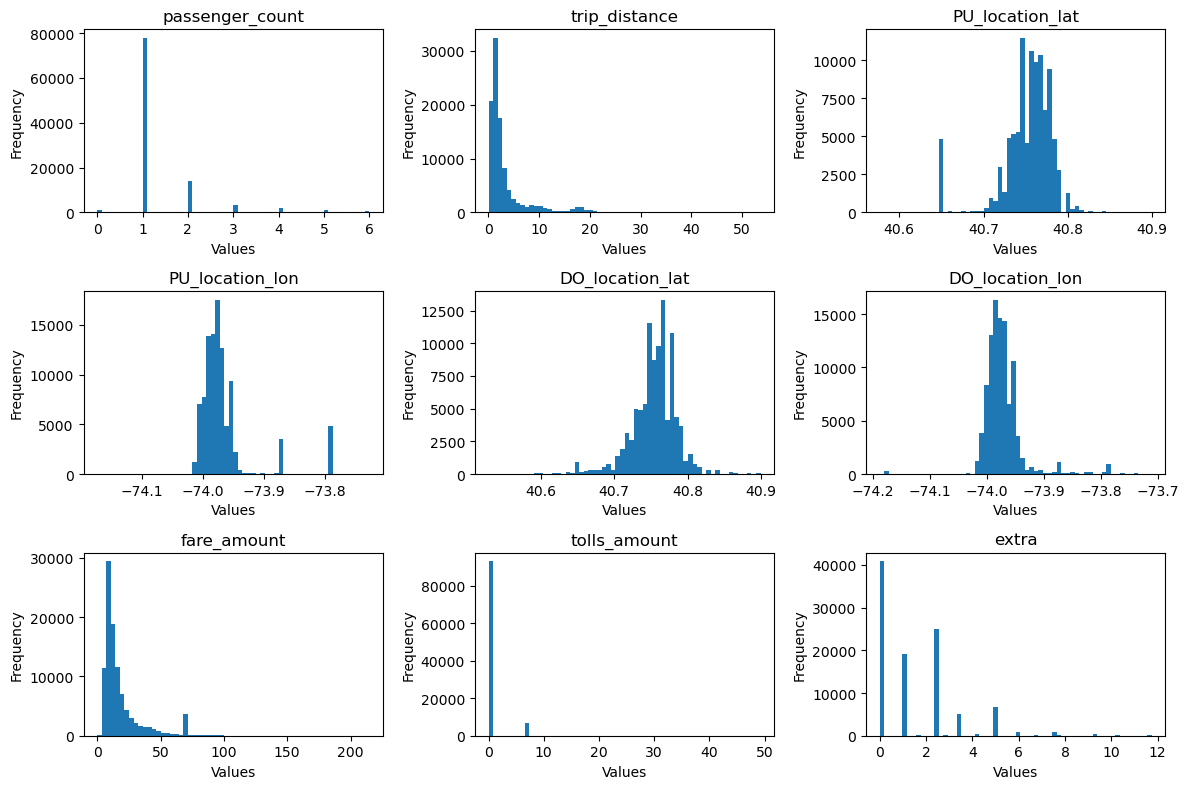

In [34]:
# Distribution des variables quantitatives
fig, axes = plt.subplots(3,3,figsize=(12,8))
axes = axes.flatten()
for i,col in enumerate(quantitative_vars):
  axes[i].hist(df_filtered[col],bins=60)
  axes[i].set_title(col)
  axes[i].set_xlabel('Values')
  axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

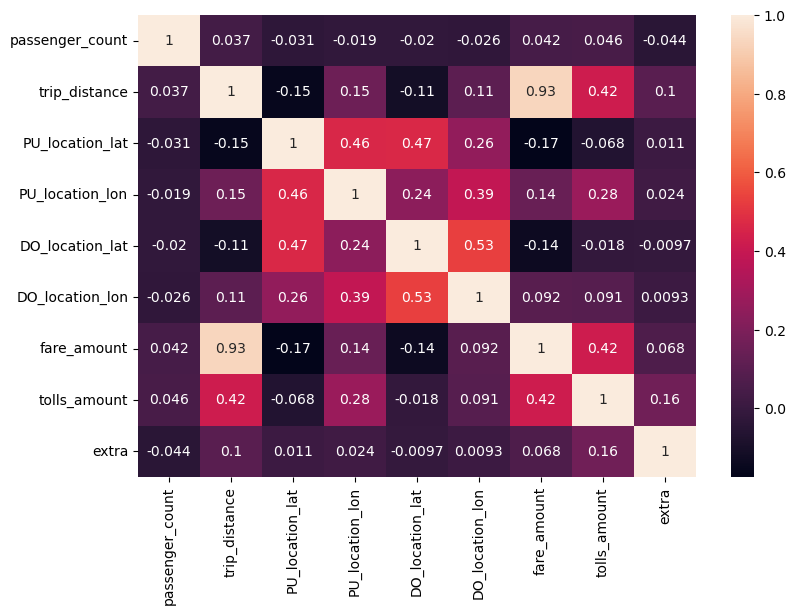

In [29]:
# Matrice des corrélationdes variables quantitatives
df_corr = df_filtered[quantitative_vars].corr(method='spearman')
plt.figure(figsize=(9,6))
sns.heatmap(df_corr,annot=True)
plt.show()

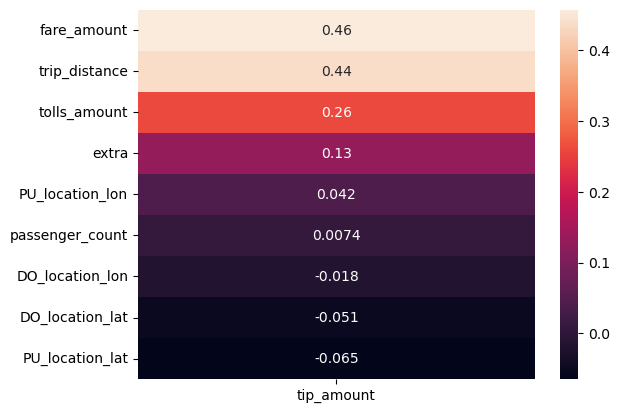

In [30]:
df_corr2 = df_filtered[quantitative_vars+['tip_amount']].corr(method='spearman')
target_spearman_corr = df_corr2[['tip_amount']].drop('tip_amount').sort_values(by='tip_amount', ascending=False)
plt.figure()
sns.heatmap(target_spearman_corr,annot=True)
plt.show()

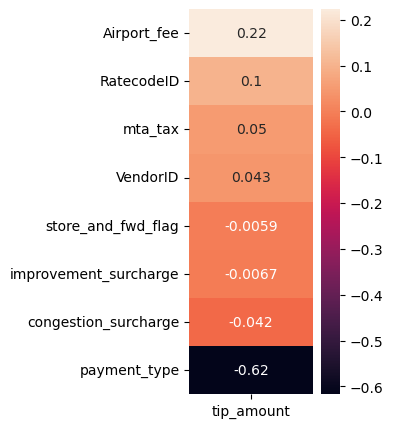

In [31]:
df_corr3 = df_filtered[[var for var in qualitative_vars if var not in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']]+[variable_cible]].corr(method='spearman')
target_spearman_corr2 = df_corr3[[variable_cible]].drop(variable_cible).sort_values(by='tip_amount', ascending=False)
plt.figure(figsize=(2,5))
sns.heatmap(target_spearman_corr2,annot=True)
plt.show()

# Importance des variables

Nous calculons l'importance des variables. Nous excluons **tpep_pickup_datetime** et **tpep_dropoff_datetime** car nous transformerons ces variables plus tard.

Text(0.5, 0, 'Importance')

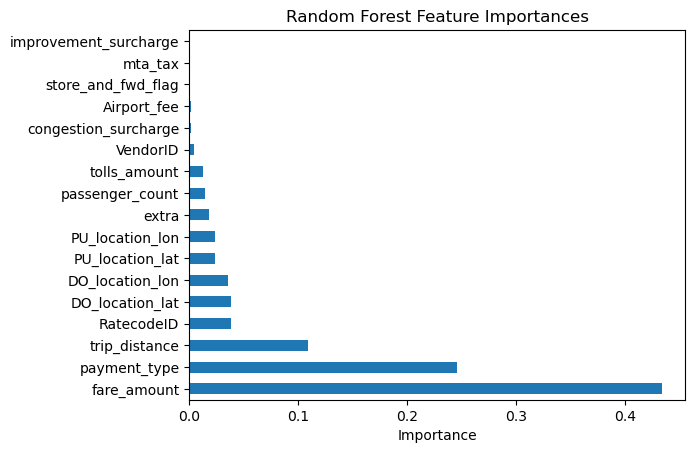

In [33]:
# Via randomForest
X = df_filtered.drop(['tip_amount', 'tpep_pickup_datetime', 'tpep_dropoff_datetime'],axis=1)
y = df_filtered['tip_amount']

# Entrainer un modele de Random Forest
rfc_model = RandomForestRegressor()
rfc_model.fit(X, y)
imp = rfc_model.feature_importances_
forest_imp = pd.Series(imp, index = X.columns)
forest_imp = forest_imp.sort_values(ascending=False)

# Plot les importances
fig = plt.figure()

forest_imp.plot.barh()
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')